In [39]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [40]:
import numpy as np
import matplotlib.pyplot as pl
from corner import hist2d
from astropy.table import Table
from tqdm import tqdm_notebook
np.random.seed(42)

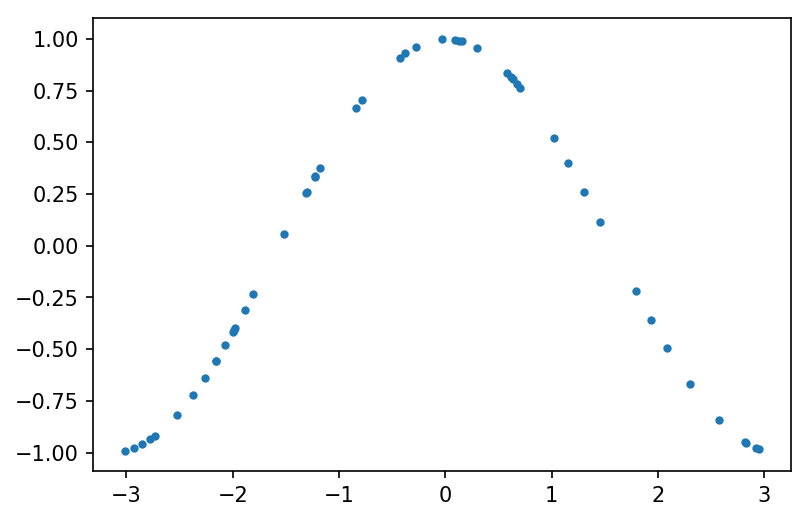

In [41]:
def func(x):
    return np.cos(x)

npts = 50
noise = 0
X = np.atleast_2d(np.random.uniform(-np.pi,np.pi,npts)).T
y = func(X[:,0]) + np.random.normal(0,noise,len(X))
pl.plot(X,y,c='C0',marker='.',ls='none')
pl.show()

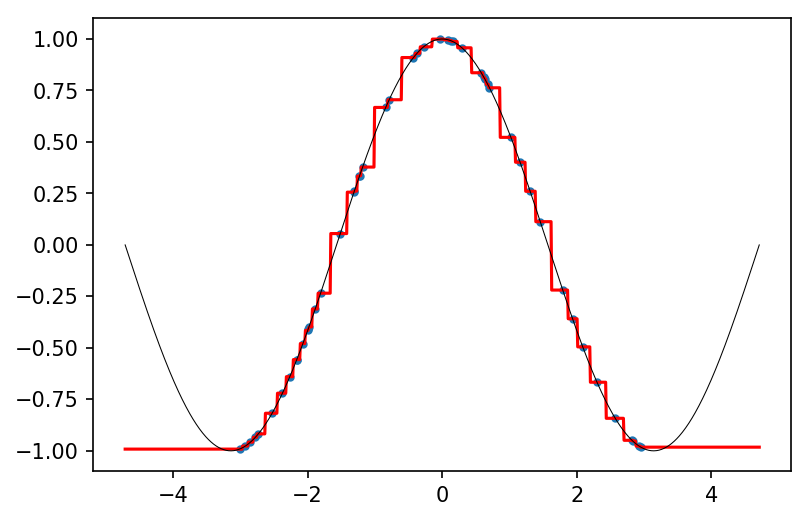

In [42]:
from sklearn.tree import DecisionTreeRegressor 

max_depth = None
tree = DecisionTreeRegressor(max_depth=max_depth)
fit = tree.fit(X, y)
X_reg = np.atleast_2d(np.linspace(-1.5*np.pi, 1.5*np.pi, 1000)).T
y_reg = tree.predict(X_reg)

pl.plot(X,y,c='C0',marker='.',ls='none')
pl.plot(X_reg,y_reg,'r')
pl.plot(X_reg,func(X_reg),'k-',lw=0.5)
pl.show()

CPU times: user 267 ms, sys: 89.1 ms, total: 356 ms
Wall time: 398 ms


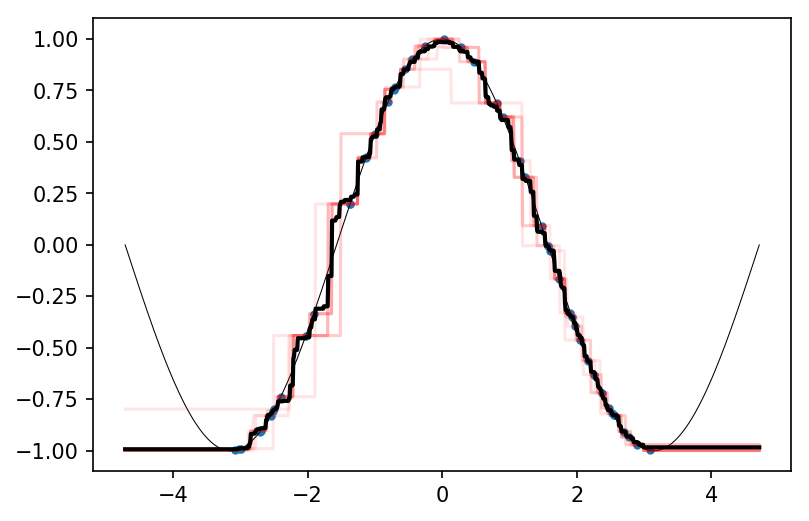

In [20]:
from sklearn.ensemble import RandomForestRegressor 
rf = RandomForestRegressor(n_estimators=200,max_features=1,max_depth=max_depth,n_jobs=8, verbose=False, oob_score=True)
%time fit = rf.fit(X, y)
y_reg = rf.predict(X_reg)

pl.plot(X,y,c='C0',marker='.',ls='none')
pl.plot(X_reg,func(X_reg),'k-',lw=0.5)

for i in range(10):
    pl.plot(X_reg,rf.estimators_[i].predict(X_reg),'r',alpha=0.1)

pl.plot(X_reg,y_reg,'k',lw=2)
pl.show()



In [21]:
t = Table.read('data/dataset.dat', format='ascii.commented_header',data_end=100000)


In [22]:
X = np.array([t['r_mag'], t['(u-g)'], t['(g-r)'], t['(r-i)'], t['(i-z)']]).T
y = np.array(t['specz'])


Text(0.5,0,'specz')

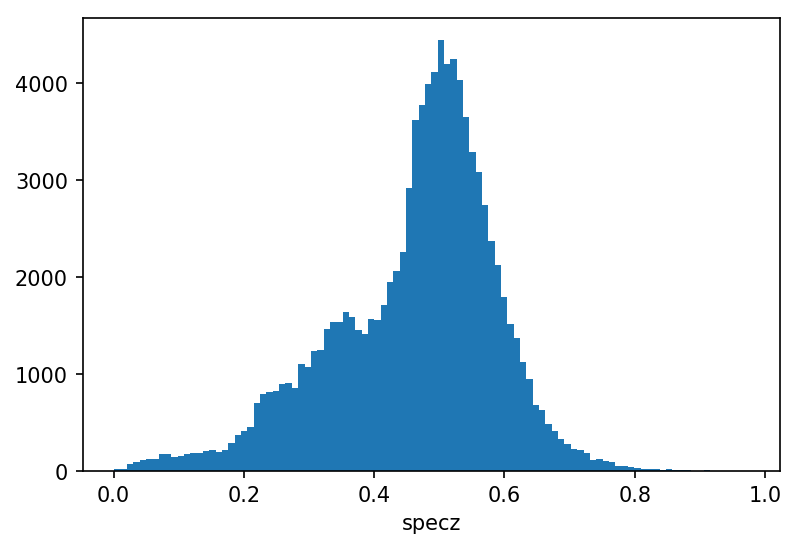

In [23]:
_ = pl.hist(y, bins=100)
pl.xlabel('specz')

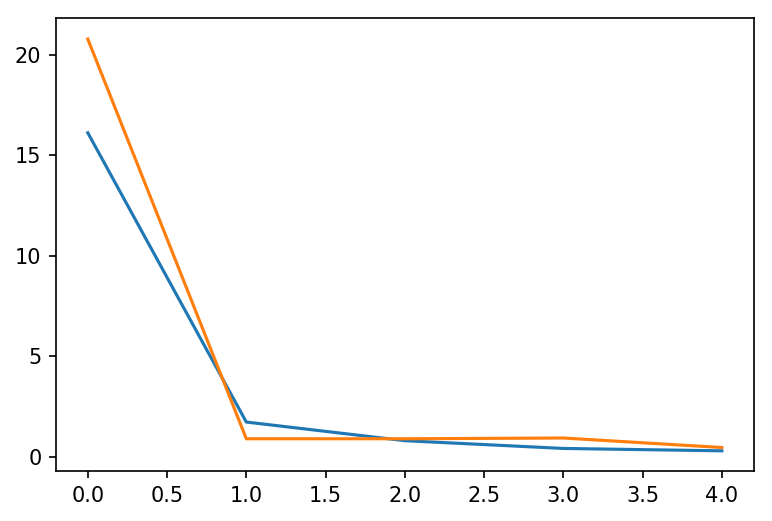

In [24]:
#low z
lowz = X[y<0.1]
pl.plot(np.mean(lowz,0))
#high z
lowz = X[y>0.8]
pl.plot(np.mean(lowz,0))


In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
X_train.shape


(90000, 5)

In [26]:
from sklearn.ensemble import RandomForestRegressor 
rf = RandomForestRegressor(n_estimators=10,max_features='auto',max_depth=10,n_jobs=8, verbose=False, oob_score=False)
%time fit = rf.fit(X_train, y_train)
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
mse_scorer = make_scorer(mean_squared_error)
score = []
max_depth_list = []
for i in tqdm_notebook(range(1,6,1)):
        rf.set_params(max_features=i)
        max_depth_list.append(i)
        score.append(cross_val_score(rf, X_train, X_train, scoring=mse_scorer, cv=5))



CPU times: user 4.47 s, sys: 22.9 ms, total: 4.49 s
Wall time: 833 ms


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

In [27]:
from sklearn.model_selection import GridSearchCV
param_grid = [
  {
   'max_features': [1, 2, 3, 4, 5], 
#    'max_depth': range(1,20,2)
  },
 ]
GridSearchR = GridSearchCV(rf,param_grid,scoring=mse_scorer,cv=5,verbose=1,n_jobs=8,return_train_score=True)
GridSearchR.fit(X_train, y_train)



Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:   10.0s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=8, oob_score=False, random_state=None,
           verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid=[{'max_features': [1, 2, 3, 4, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(mean_squared_error), verbose=1)

In [28]:
# print(GridSearchR.cv_results_)
param = GridSearchR.cv_results_['param_max_features'].data
mean_train = GridSearchR.cv_results_['mean_train_score']
mean_test = GridSearchR.cv_results_['mean_test_score']
std_train = GridSearchR.cv_results_['std_train_score']
std_test = GridSearchR.cv_results_['std_test_score']
param

array([1, 2, 3, 4, 5], dtype=object)

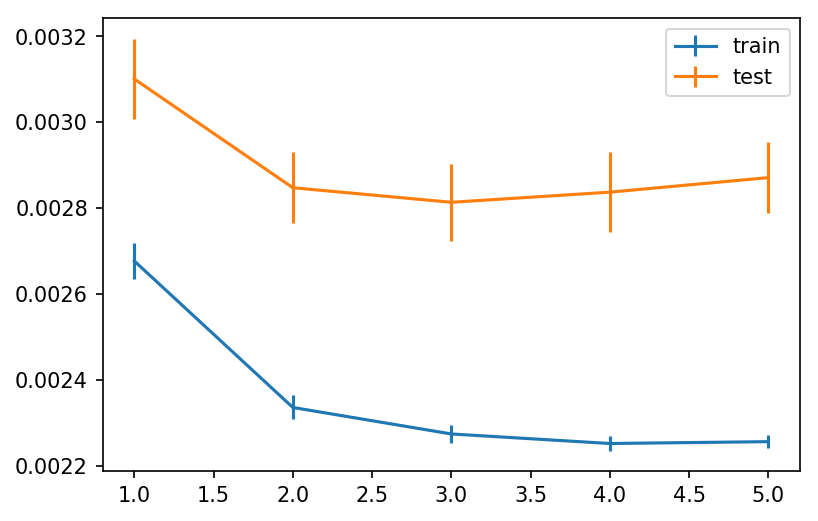

In [29]:
pl.errorbar(param,mean_train,std_train,label='train')
pl.errorbar(param,mean_test,std_test,label='test')
pl.legend()

In [30]:
from sklearn.model_selection import GridSearchCV
param_grid = [
  {
   'max_features': [1, 2, 3, 4, 5], 
   'max_depth': range(1,20,2)
  },
 ]
GridSearchR = GridSearchCV(rf,param_grid,scoring=mse_scorer,cv=5,verbose=1,n_jobs=8,return_train_score=True)
GridSearchR.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   56.6s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:  1.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=8, oob_score=False, random_state=None,
           verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid=[{'max_features': [1, 2, 3, 4, 5], 'max_depth': range(1, 20, 2)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(mean_squared_error), verbose=1)

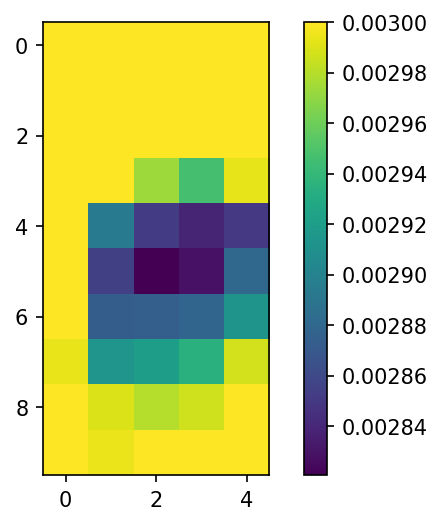

In [31]:
param = GridSearchR.cv_results_['param_max_features'].data
mean_train = GridSearchR.cv_results_['mean_train_score']
mean_test = GridSearchR.cv_results_['mean_test_score']
std_train = GridSearchR.cv_results_['std_train_score']
std_test = GridSearchR.cv_results_['std_test_score']

pl.imshow(mean_test.reshape(-1,5),vmax=0.003)
pl.colorbar()

In [32]:
%time y_pred = rf.predict(X_test)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
mse_scorer = make_scorer(mean_squared_error)
rf.score
diff = y_pred-y_test


CPU times: user 16.4 ms, sys: 3.86 ms, total: 20.3 ms
Wall time: 108 ms


Text(0.5,1,'bias:-0.000, std:0.053')

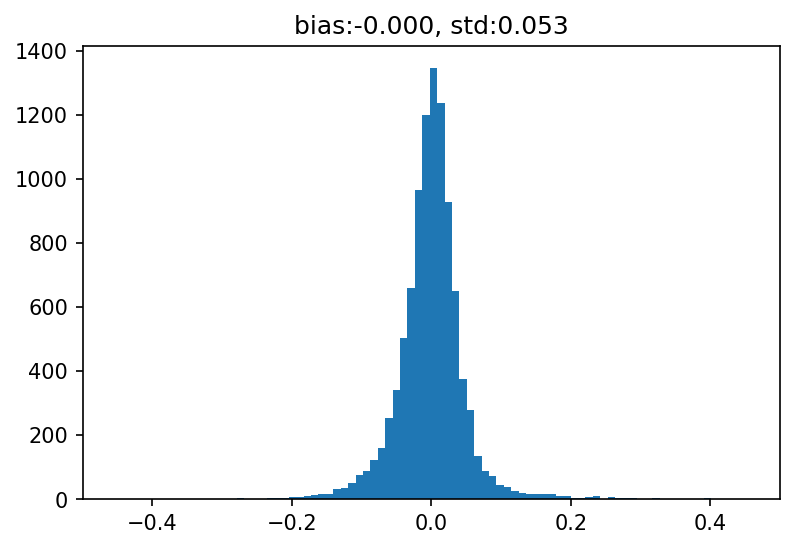

In [33]:
_ = pl.hist(y_pred-y_test, bins=100)
pl.xlim([-0.5,0.5])
pl.title("bias:{:5.3f}, std:{:5.3f}".format(np.mean(diff), np.std(diff)))

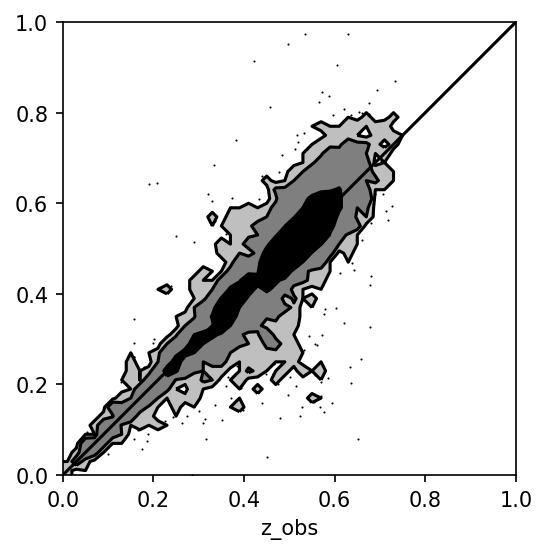

In [34]:
fig, ax = pl.subplots()
hist2d(y_pred,y_test,bins=50,ax=ax,range=[[0,1],[0,1]],levels=[0.68,0.95,0.997],plot_density=False,fill_contours=True,data_kwargs={'alpha':1,'marker':'.'})
ax.set_aspect('equal')
ax.set_xlabel("z_pred")
ax.set_xlabel("z_obs")
pl.plot([0,1],[0,1],'k-')

In [35]:
rf.feature_importances_

array([0.12050695, 0.02453066, 0.09370669, 0.75115154, 0.01010416])

In [36]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
mse_scorer = make_scorer(mean_squared_error)
dataset = load_boston()
X_full, y_full = dataset.data, dataset.target
n_samples = X_full.shape[0]
n_features = X_full.shape[1]

In [37]:
estimator = RandomForestRegressor(random_state=0, n_estimators=100)
score = cross_val_score(estimator, X_full, y_full, scoring=mse_scorer).mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = 28.95
